In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[8].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [ ]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:02<00:00,  3.69it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:20<00:00,  3.03it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   1%|          | 11/2000 [00:00<01:05, 30.57it/s]

Epoch 10/2000, Loss: 0.5910
Test Accuracy at Epoch 10: 61.05%
Test F1-score at Epoch 10: 0.6186
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.63      0.58      0.60       194
non_infringement       0.59      0.65      0.62       186

        accuracy                           0.61       380
       macro avg       0.61      0.61      0.61       380
    weighted avg       0.61      0.61      0.61       380

New best model saved with F1-score 0.6186 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.63      0.58      0.60       194
non_infringement       0.59      0.65      0.62       186

        accuracy                           0.61       380
       macro avg       0.61      0.61      0.61       380
    weighted avg       0.61      0.61      0.61       380



Training Epochs:   1%|▏         | 25/2000 [00:00<00:57, 34.60it/s]

Epoch 20/2000, Loss: 0.4333
Test Accuracy at Epoch 20: 69.47%
Test F1-score at Epoch 20: 0.7339
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.80      0.54      0.64       194
non_infringement       0.64      0.86      0.73       186

        accuracy                           0.69       380
       macro avg       0.72      0.70      0.69       380
    weighted avg       0.72      0.69      0.69       380

New best model saved with F1-score 0.7339 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.80      0.54      0.64       194
non_infringement       0.64      0.86      0.73       186

        accuracy                           0.69       380
       macro avg       0.72      0.70      0.69       380
    weighted avg       0.72      0.69      0.69       380



Training Epochs:   2%|▏         | 38/2000 [00:01<00:52, 37.70it/s]

Epoch 30/2000, Loss: 0.3643
Test Accuracy at Epoch 30: 70.26%
Test F1-score at Epoch 30: 0.7277
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.67       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:   2%|▏         | 42/2000 [00:01<00:59, 32.68it/s]

Epoch 40/2000, Loss: 0.3372
Test Accuracy at Epoch 40: 71.32%
Test F1-score at Epoch 40: 0.7373
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.68       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.73      0.71      0.71       380

New best model saved with F1-score 0.7373 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.68       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.73      0.71      0.71       380



Training Epochs:   3%|▎         | 55/2000 [00:01<00:51, 37.41it/s]

Epoch 50/2000, Loss: 0.3194
Test Accuracy at Epoch 50: 71.58%
Test F1-score at Epoch 50: 0.7488
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.82      0.57      0.67       194
non_infringement       0.66      0.87      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.71       380
    weighted avg       0.74      0.72      0.71       380

New best model saved with F1-score 0.7488 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.82      0.57      0.67       194
non_infringement       0.66      0.87      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.71       380
    weighted avg       0.74      0.72      0.71       380



Training Epochs:   3%|▎         | 68/2000 [00:01<00:50, 38.33it/s]

Epoch 60/2000, Loss: 0.2990
Test Accuracy at Epoch 60: 70.53%
Test F1-score at Epoch 60: 0.7346
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.67       194
non_infringement       0.66      0.83      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:   4%|▎         | 72/2000 [00:02<00:56, 34.12it/s]

Epoch 70/2000, Loss: 0.2772
Test Accuracy at Epoch 70: 71.32%
Test F1-score at Epoch 70: 0.7411
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.79      0.59      0.68       194
non_infringement       0.66      0.84      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.71      0.71       380



Training Epochs:   4%|▍         | 85/2000 [00:02<01:01, 31.27it/s]

Epoch 80/2000, Loss: 0.2482
Test Accuracy at Epoch 80: 70.00%
Test F1-score at Epoch 80: 0.7273
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:   5%|▍         | 95/2000 [00:02<00:53, 35.77it/s]

Epoch 90/2000, Loss: 0.2348
Test Accuracy at Epoch 90: 71.58%
Test F1-score at Epoch 90: 0.7465
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.81      0.58      0.68       194
non_infringement       0.66      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.74      0.72      0.71       380



Training Epochs:   5%|▌         | 103/2000 [00:03<00:55, 34.11it/s]

Epoch 100/2000, Loss: 0.2017
Test Accuracy at Epoch 100: 71.05%
Test F1-score at Epoch 100: 0.7304
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.77      0.62      0.69       194
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:   6%|▌         | 112/2000 [00:03<00:56, 33.24it/s]

Epoch 110/2000, Loss: 0.1805
Test Accuracy at Epoch 110: 69.74%
Test F1-score at Epoch 110: 0.7242
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.66       194
non_infringement       0.65      0.81      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.70      0.69       380



Training Epochs:   6%|▋         | 125/2000 [00:03<00:49, 37.53it/s]

Epoch 120/2000, Loss: 0.1634
Test Accuracy at Epoch 120: 70.79%
Test F1-score at Epoch 120: 0.7363
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.79      0.59      0.67       194
non_infringement       0.66      0.83      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:   7%|▋         | 133/2000 [00:03<00:54, 34.08it/s]

Epoch 130/2000, Loss: 0.1497
Test Accuracy at Epoch 130: 70.79%
Test F1-score at Epoch 130: 0.7363
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.79      0.59      0.67       194
non_infringement       0.66      0.83      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:   7%|▋         | 147/2000 [00:04<00:52, 35.25it/s]

Epoch 140/2000, Loss: 0.1405
Test Accuracy at Epoch 140: 72.37%
Test F1-score at Epoch 140: 0.7458
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:   8%|▊         | 155/2000 [00:04<00:55, 33.21it/s]

Epoch 150/2000, Loss: 0.1374
Test Accuracy at Epoch 150: 71.32%
Test F1-score at Epoch 150: 0.7423
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       194
non_infringement       0.66      0.84      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.71      0.71       380



Training Epochs:   8%|▊         | 165/2000 [00:04<00:49, 37.17it/s]

Epoch 160/2000, Loss: 0.1326
Test Accuracy at Epoch 160: 70.53%
Test F1-score at Epoch 160: 0.7333
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       194
non_infringement       0.66      0.83      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:   9%|▊         | 173/2000 [00:05<00:55, 32.78it/s]

Epoch 170/2000, Loss: 0.1272
Test Accuracy at Epoch 170: 73.95%
Test F1-score at Epoch 170: 0.7568
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

New best model saved with F1-score 0.7568 at epoch 170
Best Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:   9%|▉         | 182/2000 [00:05<00:56, 31.92it/s]

Epoch 180/2000, Loss: 0.1242
Test Accuracy at Epoch 180: 72.11%
Test F1-score at Epoch 180: 0.7440
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.69       194
non_infringement       0.68      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  10%|▉         | 195/2000 [00:05<00:54, 32.83it/s]

Epoch 190/2000, Loss: 0.1213
Test Accuracy at Epoch 190: 70.53%
Test F1-score at Epoch 190: 0.7333
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       194
non_infringement       0.66      0.83      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  10%|█         | 203/2000 [00:05<00:51, 34.71it/s]

Epoch 200/2000, Loss: 0.1193
Test Accuracy at Epoch 200: 73.95%
Test F1-score at Epoch 200: 0.7568
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  11%|█         | 217/2000 [00:06<00:50, 34.97it/s]

Epoch 210/2000, Loss: 0.1220
Test Accuracy at Epoch 210: 70.26%
Test F1-score at Epoch 210: 0.7316
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.67       194
non_infringement       0.66      0.83      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  11%|█▏        | 225/2000 [00:06<00:54, 32.80it/s]

Epoch 220/2000, Loss: 0.1146
Test Accuracy at Epoch 220: 71.58%
Test F1-score at Epoch 220: 0.7379
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.78      0.62      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  12%|█▏        | 235/2000 [00:06<00:48, 36.59it/s]

Epoch 230/2000, Loss: 0.1145
Test Accuracy at Epoch 230: 73.68%
Test F1-score at Epoch 230: 0.7512
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  12%|█▏        | 243/2000 [00:07<00:52, 33.58it/s]

Epoch 240/2000, Loss: 0.1137
Test Accuracy at Epoch 240: 73.42%
Test F1-score at Epoch 240: 0.7506
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.72       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  13%|█▎        | 257/2000 [00:07<00:49, 34.87it/s]

Epoch 250/2000, Loss: 0.1100
Test Accuracy at Epoch 250: 70.00%
Test F1-score at Epoch 250: 0.7286
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.77      0.58      0.66       194
non_infringement       0.65      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  13%|█▎        | 265/2000 [00:07<00:53, 32.18it/s]

Epoch 260/2000, Loss: 0.1098
Test Accuracy at Epoch 260: 69.21%
Test F1-score at Epoch 260: 0.7221
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.77      0.57      0.65       194
non_infringement       0.65      0.82      0.72       186

        accuracy                           0.69       380
       macro avg       0.71      0.69      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  14%|█▎        | 274/2000 [00:08<00:51, 33.57it/s]

Epoch 270/2000, Loss: 0.1088
Test Accuracy at Epoch 270: 70.79%
Test F1-score at Epoch 270: 0.7325
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.68       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  14%|█▍        | 287/2000 [00:08<00:48, 35.27it/s]

Epoch 280/2000, Loss: 0.1072
Test Accuracy at Epoch 280: 70.79%
Test F1-score at Epoch 280: 0.7325
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.68       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  15%|█▍        | 296/2000 [00:08<00:49, 34.73it/s]

Epoch 290/2000, Loss: 0.1066
Test Accuracy at Epoch 290: 71.32%
Test F1-score at Epoch 290: 0.7348
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.77      0.62      0.69       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  15%|█▌        | 304/2000 [00:08<00:52, 32.12it/s]

Epoch 300/2000, Loss: 0.1058
Test Accuracy at Epoch 300: 70.79%
Test F1-score at Epoch 300: 0.7325
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.68       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  16%|█▌        | 313/2000 [00:09<00:47, 35.72it/s]

Epoch 310/2000, Loss: 0.1111
Test Accuracy at Epoch 310: 68.42%
Test F1-score at Epoch 310: 0.7170
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.76      0.56      0.64       194
non_infringement       0.64      0.82      0.72       186

        accuracy                           0.68       380
       macro avg       0.70      0.69      0.68       380
    weighted avg       0.70      0.68      0.68       380



Training Epochs:  16%|█▋        | 327/2000 [00:09<00:44, 37.62it/s]

Epoch 320/2000, Loss: 0.1052
Test Accuracy at Epoch 320: 71.05%
Test F1-score at Epoch 320: 0.7330
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  17%|█▋        | 335/2000 [00:09<00:48, 34.59it/s]

Epoch 330/2000, Loss: 0.1066
Test Accuracy at Epoch 330: 73.42%
Test F1-score at Epoch 330: 0.7494
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  17%|█▋        | 345/2000 [00:10<00:43, 37.80it/s]

Epoch 340/2000, Loss: 0.1038
Test Accuracy at Epoch 340: 71.32%
Test F1-score at Epoch 340: 0.7348
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.77      0.62      0.69       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  18%|█▊        | 353/2000 [00:10<00:47, 34.56it/s]

Epoch 350/2000, Loss: 0.1035
Test Accuracy at Epoch 350: 70.79%
Test F1-score at Epoch 350: 0.7312
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  18%|█▊        | 367/2000 [00:10<00:46, 35.08it/s]

Epoch 360/2000, Loss: 0.1030
Test Accuracy at Epoch 360: 71.32%
Test F1-score at Epoch 360: 0.7348
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.77      0.62      0.69       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  19%|█▉        | 375/2000 [00:10<00:48, 33.43it/s]

Epoch 370/2000, Loss: 0.1033
Test Accuracy at Epoch 370: 73.16%
Test F1-score at Epoch 370: 0.7463
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.78      0.66      0.72       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  19%|█▉        | 385/2000 [00:11<00:44, 36.70it/s]

Epoch 380/2000, Loss: 0.1041
Test Accuracy at Epoch 380: 72.63%
Test F1-score at Epoch 380: 0.7400
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  20%|█▉        | 393/2000 [00:11<00:46, 34.20it/s]

Epoch 390/2000, Loss: 0.1018
Test Accuracy at Epoch 390: 71.05%
Test F1-score at Epoch 390: 0.7330
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  20%|██        | 402/2000 [00:11<00:50, 31.87it/s]

Epoch 400/2000, Loss: 0.1020
Test Accuracy at Epoch 400: 70.53%
Test F1-score at Epoch 400: 0.7295
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.68       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  21%|██        | 415/2000 [00:12<00:48, 32.36it/s]

Epoch 410/2000, Loss: 0.1021
Test Accuracy at Epoch 410: 72.63%
Test F1-score at Epoch 410: 0.7400
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  21%|██▏       | 425/2000 [00:12<00:43, 35.92it/s]

Epoch 420/2000, Loss: 0.1042
Test Accuracy at Epoch 420: 70.53%
Test F1-score at Epoch 420: 0.7295
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.68       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  22%|██▏       | 433/2000 [00:12<00:45, 34.14it/s]

Epoch 430/2000, Loss: 0.1023
Test Accuracy at Epoch 430: 70.53%
Test F1-score at Epoch 430: 0.7295
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.68       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  22%|██▏       | 442/2000 [00:12<00:43, 36.01it/s]

Epoch 440/2000, Loss: 0.1010
Test Accuracy at Epoch 440: 71.05%
Test F1-score at Epoch 440: 0.7356
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.78      0.60      0.68       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  23%|██▎       | 455/2000 [00:13<00:43, 35.55it/s]

Epoch 450/2000, Loss: 0.1005
Test Accuracy at Epoch 450: 71.32%
Test F1-score at Epoch 450: 0.7361
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  23%|██▎       | 463/2000 [00:13<00:47, 32.65it/s]

Epoch 460/2000, Loss: 0.1002
Test Accuracy at Epoch 460: 71.32%
Test F1-score at Epoch 460: 0.7361
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  24%|██▍       | 477/2000 [00:13<00:44, 34.25it/s]

Epoch 470/2000, Loss: 0.1000
Test Accuracy at Epoch 470: 72.63%
Test F1-score at Epoch 470: 0.7451
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  24%|██▍       | 485/2000 [00:14<00:46, 32.42it/s]

Epoch 480/2000, Loss: 0.0998
Test Accuracy at Epoch 480: 72.37%
Test F1-score at Epoch 480: 0.7433
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  25%|██▍       | 495/2000 [00:14<00:42, 35.63it/s]

Epoch 490/2000, Loss: 0.1009
Test Accuracy at Epoch 490: 69.21%
Test F1-score at Epoch 490: 0.7247
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.77      0.56      0.65       194
non_infringement       0.64      0.83      0.72       186

        accuracy                           0.69       380
       macro avg       0.71      0.69      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  25%|██▌       | 503/2000 [00:14<00:45, 32.86it/s]

Epoch 500/2000, Loss: 0.1080
Test Accuracy at Epoch 500: 74.21%
Test F1-score at Epoch 500: 0.7461
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.77      0.71      0.74       194
non_infringement       0.72      0.77      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  26%|██▌       | 517/2000 [00:15<00:46, 32.22it/s]

Epoch 510/2000, Loss: 0.1011
Test Accuracy at Epoch 510: 75.00%
Test F1-score at Epoch 510: 0.7583
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

New best model saved with F1-score 0.7583 at epoch 510
Best Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  26%|██▌       | 521/2000 [00:15<00:49, 29.70it/s]

Epoch 520/2000, Loss: 0.0999
Test Accuracy at Epoch 520: 75.00%
Test F1-score at Epoch 520: 0.7607
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

New best model saved with F1-score 0.7607 at epoch 520
Best Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  27%|██▋       | 534/2000 [00:15<00:47, 30.82it/s]

Epoch 530/2000, Loss: 0.0992
Test Accuracy at Epoch 530: 75.00%
Test F1-score at Epoch 530: 0.7607
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  27%|██▋       | 542/2000 [00:15<00:44, 32.92it/s]

Epoch 540/2000, Loss: 0.0990
Test Accuracy at Epoch 540: 72.37%
Test F1-score at Epoch 540: 0.7420
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  28%|██▊       | 555/2000 [00:16<00:42, 34.01it/s]

Epoch 550/2000, Loss: 0.0989
Test Accuracy at Epoch 550: 72.37%
Test F1-score at Epoch 550: 0.7420
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  28%|██▊       | 563/2000 [00:16<00:45, 31.46it/s]

Epoch 560/2000, Loss: 0.0987
Test Accuracy at Epoch 560: 73.16%
Test F1-score at Epoch 560: 0.7475
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  29%|██▊       | 572/2000 [00:16<00:40, 35.10it/s]

Epoch 570/2000, Loss: 0.0986
Test Accuracy at Epoch 570: 72.37%
Test F1-score at Epoch 570: 0.7420
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  29%|██▉       | 585/2000 [00:17<00:40, 35.31it/s]

Epoch 580/2000, Loss: 0.0984
Test Accuracy at Epoch 580: 73.16%
Test F1-score at Epoch 580: 0.7475
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  30%|██▉       | 598/2000 [00:17<00:38, 36.65it/s]

Epoch 590/2000, Loss: 0.0984
Test Accuracy at Epoch 590: 73.16%
Test F1-score at Epoch 590: 0.7475
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  30%|███       | 602/2000 [00:17<00:43, 32.44it/s]

Epoch 600/2000, Loss: 0.1048
Test Accuracy at Epoch 600: 75.00%
Test F1-score at Epoch 600: 0.7583
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  31%|███       | 615/2000 [00:18<00:41, 33.58it/s]

Epoch 610/2000, Loss: 0.0989
Test Accuracy at Epoch 610: 75.00%
Test F1-score at Epoch 610: 0.7583
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  31%|███▏      | 625/2000 [00:18<00:37, 36.44it/s]

Epoch 620/2000, Loss: 0.0997
Test Accuracy at Epoch 620: 72.89%
Test F1-score at Epoch 620: 0.7457
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  32%|███▏      | 633/2000 [00:18<00:40, 33.74it/s]

Epoch 630/2000, Loss: 0.0989
Test Accuracy at Epoch 630: 72.11%
Test F1-score at Epoch 630: 0.7415
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  32%|███▏      | 642/2000 [00:18<00:41, 32.73it/s]

Epoch 640/2000, Loss: 0.0982
Test Accuracy at Epoch 640: 72.11%
Test F1-score at Epoch 640: 0.7415
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  33%|███▎      | 655/2000 [00:19<00:41, 32.71it/s]

Epoch 650/2000, Loss: 0.0977
Test Accuracy at Epoch 650: 73.16%
Test F1-score at Epoch 650: 0.7488
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.71       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  33%|███▎      | 664/2000 [00:19<00:38, 35.12it/s]

Epoch 660/2000, Loss: 0.0977
Test Accuracy at Epoch 660: 73.42%
Test F1-score at Epoch 660: 0.7494
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  34%|███▍      | 678/2000 [00:19<00:36, 36.53it/s]

Epoch 670/2000, Loss: 0.0976
Test Accuracy at Epoch 670: 73.42%
Test F1-score at Epoch 670: 0.7506
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.72       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  34%|███▍      | 686/2000 [00:20<00:38, 34.56it/s]

Epoch 680/2000, Loss: 0.0974
Test Accuracy at Epoch 680: 73.68%
Test F1-score at Epoch 680: 0.7525
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.82      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  35%|███▍      | 695/2000 [00:20<00:34, 37.93it/s]

Epoch 690/2000, Loss: 0.0974
Test Accuracy at Epoch 690: 73.42%
Test F1-score at Epoch 690: 0.7494
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  35%|███▌      | 703/2000 [00:20<00:37, 35.02it/s]

Epoch 700/2000, Loss: 0.1005
Test Accuracy at Epoch 700: 75.00%
Test F1-score at Epoch 700: 0.7583
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  36%|███▌      | 712/2000 [00:20<00:38, 33.80it/s]

Epoch 710/2000, Loss: 0.0984
Test Accuracy at Epoch 710: 70.26%
Test F1-score at Epoch 710: 0.7290
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  36%|███▌      | 721/2000 [00:21<00:36, 35.32it/s]

Epoch 720/2000, Loss: 0.0979
Test Accuracy at Epoch 720: 75.26%
Test F1-score at Epoch 720: 0.7626
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

New best model saved with F1-score 0.7626 at epoch 720
Best Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  37%|███▋      | 735/2000 [00:21<00:34, 36.76it/s]

Epoch 730/2000, Loss: 0.0974
Test Accuracy at Epoch 730: 72.11%
Test F1-score at Epoch 730: 0.7415
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  37%|███▋      | 745/2000 [00:21<00:35, 35.84it/s]

Epoch 740/2000, Loss: 0.0969
Test Accuracy at Epoch 740: 73.42%
Test F1-score at Epoch 740: 0.7494
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  38%|███▊      | 754/2000 [00:22<00:35, 34.85it/s]

Epoch 750/2000, Loss: 0.0974
Test Accuracy at Epoch 750: 73.42%
Test F1-score at Epoch 750: 0.7494
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  38%|███▊      | 768/2000 [00:22<00:31, 38.86it/s]

Epoch 760/2000, Loss: 0.0969
Test Accuracy at Epoch 760: 73.42%
Test F1-score at Epoch 760: 0.7494
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  39%|███▉      | 777/2000 [00:22<00:33, 36.13it/s]

Epoch 770/2000, Loss: 0.0993
Test Accuracy at Epoch 770: 75.53%
Test F1-score at Epoch 770: 0.7646
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380

New best model saved with F1-score 0.7646 at epoch 770
Best Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  39%|███▉      | 785/2000 [00:22<00:35, 33.79it/s]

Epoch 780/2000, Loss: 0.0967
Test Accuracy at Epoch 780: 72.63%
Test F1-score at Epoch 780: 0.7451
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  40%|███▉      | 795/2000 [00:23<00:32, 37.45it/s]

Epoch 790/2000, Loss: 0.0973
Test Accuracy at Epoch 790: 72.63%
Test F1-score at Epoch 790: 0.7451
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  40%|████      | 803/2000 [00:23<00:34, 34.68it/s]

Epoch 800/2000, Loss: 0.0986
Test Accuracy at Epoch 800: 75.26%
Test F1-score at Epoch 800: 0.7626
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  41%|████      | 812/2000 [00:23<00:35, 33.10it/s]

Epoch 810/2000, Loss: 0.0982
Test Accuracy at Epoch 810: 70.53%
Test F1-score at Epoch 810: 0.7308
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.67       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  41%|████▏     | 825/2000 [00:24<00:35, 33.02it/s]

Epoch 820/2000, Loss: 0.0970
Test Accuracy at Epoch 820: 75.26%
Test F1-score at Epoch 820: 0.7626
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  42%|████▏     | 834/2000 [00:24<00:33, 34.92it/s]

Epoch 830/2000, Loss: 0.0964
Test Accuracy at Epoch 830: 73.16%
Test F1-score at Epoch 830: 0.7475
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  42%|████▏     | 847/2000 [00:24<00:32, 35.72it/s]

Epoch 840/2000, Loss: 0.0975
Test Accuracy at Epoch 840: 72.11%
Test F1-score at Epoch 840: 0.7415
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  43%|████▎     | 855/2000 [00:24<00:34, 33.24it/s]

Epoch 850/2000, Loss: 0.0962
Test Accuracy at Epoch 850: 72.63%
Test F1-score at Epoch 850: 0.7451
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  43%|████▎     | 865/2000 [00:25<00:35, 32.26it/s]

Epoch 860/2000, Loss: 0.0960
Test Accuracy at Epoch 860: 73.16%
Test F1-score at Epoch 860: 0.7475
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  44%|████▍     | 877/2000 [00:25<00:31, 35.11it/s]

Epoch 870/2000, Loss: 0.0983
Test Accuracy at Epoch 870: 75.53%
Test F1-score at Epoch 870: 0.7646
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  44%|████▍     | 886/2000 [00:25<00:32, 33.95it/s]

Epoch 880/2000, Loss: 0.0985
Test Accuracy at Epoch 880: 70.53%
Test F1-score at Epoch 880: 0.7308
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.67       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  45%|████▍     | 894/2000 [00:26<00:33, 32.72it/s]

Epoch 890/2000, Loss: 0.1046
Test Accuracy at Epoch 890: 75.26%
Test F1-score at Epoch 890: 0.7626
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  45%|████▌     | 903/2000 [00:26<00:30, 36.25it/s]

Epoch 900/2000, Loss: 0.0973
Test Accuracy at Epoch 900: 73.42%
Test F1-score at Epoch 900: 0.7494
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  46%|████▌     | 916/2000 [00:26<00:29, 36.33it/s]

Epoch 910/2000, Loss: 0.0962
Test Accuracy at Epoch 910: 73.42%
Test F1-score at Epoch 910: 0.7494
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  46%|████▋     | 925/2000 [00:27<00:30, 34.95it/s]

Epoch 920/2000, Loss: 0.0964
Test Accuracy at Epoch 920: 72.89%
Test F1-score at Epoch 920: 0.7457
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  47%|████▋     | 934/2000 [00:27<00:31, 33.75it/s]

Epoch 930/2000, Loss: 0.0958
Test Accuracy at Epoch 930: 72.63%
Test F1-score at Epoch 930: 0.7451
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  47%|████▋     | 947/2000 [00:27<00:28, 36.99it/s]

Epoch 940/2000, Loss: 0.0957
Test Accuracy at Epoch 940: 73.16%
Test F1-score at Epoch 940: 0.7475
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  48%|████▊     | 951/2000 [00:27<00:38, 27.47it/s]

Epoch 950/2000, Loss: 0.0955
Test Accuracy at Epoch 950: 73.16%
Test F1-score at Epoch 950: 0.7475
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  48%|████▊     | 964/2000 [00:28<00:32, 32.05it/s]

Epoch 960/2000, Loss: 0.0955
Test Accuracy at Epoch 960: 73.16%
Test F1-score at Epoch 960: 0.7475
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  49%|████▊     | 972/2000 [00:28<00:33, 31.11it/s]

Epoch 970/2000, Loss: 0.0954
Test Accuracy at Epoch 970: 72.37%
Test F1-score at Epoch 970: 0.7420
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  49%|████▉     | 986/2000 [00:28<00:25, 39.20it/s]

Epoch 980/2000, Loss: 0.0953
Test Accuracy at Epoch 980: 72.37%
Test F1-score at Epoch 980: 0.7420
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  50%|████▉     | 996/2000 [00:29<00:26, 37.82it/s]

Epoch 990/2000, Loss: 0.0954
Test Accuracy at Epoch 990: 72.37%
Test F1-score at Epoch 990: 0.7420
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  50%|█████     | 1004/2000 [00:29<00:28, 34.98it/s]

Epoch 1000/2000, Loss: 0.0999
Test Accuracy at Epoch 1000: 70.53%
Test F1-score at Epoch 1000: 0.7308
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.67       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  51%|█████     | 1014/2000 [00:29<00:25, 38.96it/s]

Epoch 1010/2000, Loss: 0.0993
Test Accuracy at Epoch 1010: 75.26%
Test F1-score at Epoch 1010: 0.7626
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  51%|█████▏    | 1027/2000 [00:29<00:24, 39.76it/s]

Epoch 1020/2000, Loss: 0.1030
Test Accuracy at Epoch 1020: 70.26%
Test F1-score at Epoch 1020: 0.7277
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.67       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  52%|█████▏    | 1032/2000 [00:30<00:23, 40.84it/s]

Epoch 1030/2000, Loss: 0.0961
Test Accuracy at Epoch 1030: 72.63%
Test F1-score at Epoch 1030: 0.7451
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  52%|█████▏    | 1047/2000 [00:30<00:23, 41.24it/s]

Epoch 1040/2000, Loss: 0.0962
Test Accuracy at Epoch 1040: 72.89%
Test F1-score at Epoch 1040: 0.7457
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  53%|█████▎    | 1057/2000 [00:30<00:23, 39.73it/s]

Epoch 1050/2000, Loss: 0.0955
Test Accuracy at Epoch 1050: 73.16%
Test F1-score at Epoch 1050: 0.7475
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  53%|█████▎    | 1062/2000 [00:30<00:23, 40.34it/s]

Epoch 1060/2000, Loss: 0.0956
Test Accuracy at Epoch 1060: 72.63%
Test F1-score at Epoch 1060: 0.7451
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  54%|█████▍    | 1076/2000 [00:31<00:22, 40.37it/s]

Epoch 1070/2000, Loss: 0.0955
Test Accuracy at Epoch 1070: 73.16%
Test F1-score at Epoch 1070: 0.7475
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  54%|█████▍    | 1086/2000 [00:31<00:24, 37.58it/s]

Epoch 1080/2000, Loss: 0.0955
Test Accuracy at Epoch 1080: 72.37%
Test F1-score at Epoch 1080: 0.7420
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  55%|█████▍    | 1094/2000 [00:31<00:25, 34.92it/s]

Epoch 1090/2000, Loss: 0.0950
Test Accuracy at Epoch 1090: 75.00%
Test F1-score at Epoch 1090: 0.7607
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  55%|█████▌    | 1108/2000 [00:32<00:21, 41.39it/s]

Epoch 1100/2000, Loss: 0.0961
Test Accuracy at Epoch 1100: 72.37%
Test F1-score at Epoch 1100: 0.7420
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  56%|█████▌    | 1118/2000 [00:32<00:21, 40.32it/s]

Epoch 1110/2000, Loss: 0.1013
Test Accuracy at Epoch 1110: 73.68%
Test F1-score at Epoch 1110: 0.7423
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  56%|█████▌    | 1123/2000 [00:32<00:21, 41.14it/s]

Epoch 1120/2000, Loss: 0.0966
Test Accuracy at Epoch 1120: 72.63%
Test F1-score at Epoch 1120: 0.7413
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  57%|█████▋    | 1139/2000 [00:32<00:19, 43.73it/s]

Epoch 1130/2000, Loss: 0.0949
Test Accuracy at Epoch 1130: 72.63%
Test F1-score at Epoch 1130: 0.7438
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.71       194
non_infringement       0.69      0.81      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.72       380



Training Epochs:  57%|█████▋    | 1144/2000 [00:32<00:22, 38.87it/s]

Epoch 1140/2000, Loss: 0.0949
Test Accuracy at Epoch 1140: 73.16%
Test F1-score at Epoch 1140: 0.7475
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  58%|█████▊    | 1154/2000 [00:33<00:19, 42.70it/s]

Epoch 1150/2000, Loss: 0.0947
Test Accuracy at Epoch 1150: 72.37%
Test F1-score at Epoch 1150: 0.7420
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  58%|█████▊    | 1169/2000 [00:33<00:19, 42.28it/s]

Epoch 1160/2000, Loss: 0.0947
Test Accuracy at Epoch 1160: 73.16%
Test F1-score at Epoch 1160: 0.7475
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  59%|█████▊    | 1174/2000 [00:33<00:19, 41.49it/s]

Epoch 1170/2000, Loss: 0.0946
Test Accuracy at Epoch 1170: 73.16%
Test F1-score at Epoch 1170: 0.7475
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  59%|█████▉    | 1184/2000 [00:33<00:19, 41.33it/s]

Epoch 1180/2000, Loss: 0.0946
Test Accuracy at Epoch 1180: 73.16%
Test F1-score at Epoch 1180: 0.7475
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  60%|█████▉    | 1195/2000 [00:34<00:20, 39.50it/s]

Epoch 1190/2000, Loss: 0.0955
Test Accuracy at Epoch 1190: 75.00%
Test F1-score at Epoch 1190: 0.7607
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  60%|██████    | 1206/2000 [00:34<00:18, 43.85it/s]

Epoch 1200/2000, Loss: 0.0947
Test Accuracy at Epoch 1200: 72.37%
Test F1-score at Epoch 1200: 0.7420
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  61%|██████    | 1216/2000 [00:34<00:18, 41.31it/s]

Epoch 1210/2000, Loss: 0.0955
Test Accuracy at Epoch 1210: 72.63%
Test F1-score at Epoch 1210: 0.7451
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  61%|██████▏   | 1226/2000 [00:34<00:19, 39.47it/s]

Epoch 1220/2000, Loss: 0.0952
Test Accuracy at Epoch 1220: 72.89%
Test F1-score at Epoch 1220: 0.7457
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  62%|██████▏   | 1236/2000 [00:35<00:17, 42.69it/s]

Epoch 1230/2000, Loss: 0.0952
Test Accuracy at Epoch 1230: 72.37%
Test F1-score at Epoch 1230: 0.7420
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  62%|██████▏   | 1246/2000 [00:35<00:18, 40.21it/s]

Epoch 1240/2000, Loss: 0.0953
Test Accuracy at Epoch 1240: 75.00%
Test F1-score at Epoch 1240: 0.7607
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  63%|██████▎   | 1256/2000 [00:35<00:17, 42.13it/s]

Epoch 1250/2000, Loss: 0.0949
Test Accuracy at Epoch 1250: 72.63%
Test F1-score at Epoch 1250: 0.7451
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  63%|██████▎   | 1266/2000 [00:35<00:17, 40.97it/s]

Epoch 1260/2000, Loss: 0.0946
Test Accuracy at Epoch 1260: 72.89%
Test F1-score at Epoch 1260: 0.7457
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  64%|██████▍   | 1276/2000 [00:36<00:18, 39.28it/s]

Epoch 1270/2000, Loss: 0.0966
Test Accuracy at Epoch 1270: 73.95%
Test F1-score at Epoch 1270: 0.7481
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  64%|██████▍   | 1286/2000 [00:36<00:16, 42.11it/s]

Epoch 1280/2000, Loss: 0.0951
Test Accuracy at Epoch 1280: 72.11%
Test F1-score at Epoch 1280: 0.7415
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  65%|██████▍   | 1296/2000 [00:36<00:17, 39.43it/s]

Epoch 1290/2000, Loss: 0.0944
Test Accuracy at Epoch 1290: 72.63%
Test F1-score at Epoch 1290: 0.7451
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  65%|██████▌   | 1306/2000 [00:36<00:18, 37.46it/s]

Epoch 1300/2000, Loss: 0.0949
Test Accuracy at Epoch 1300: 73.95%
Test F1-score at Epoch 1300: 0.7481
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  66%|██████▌   | 1315/2000 [00:37<00:17, 39.83it/s]

Epoch 1310/2000, Loss: 0.0947
Test Accuracy at Epoch 1310: 73.42%
Test F1-score at Epoch 1310: 0.7506
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.72       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  66%|██████▌   | 1324/2000 [00:37<00:19, 35.24it/s]

Epoch 1320/2000, Loss: 0.0972
Test Accuracy at Epoch 1320: 70.79%
Test F1-score at Epoch 1320: 0.7338
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.78      0.60      0.68       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  67%|██████▋   | 1333/2000 [00:37<00:18, 35.31it/s]

Epoch 1330/2000, Loss: 0.0964
Test Accuracy at Epoch 1330: 72.89%
Test F1-score at Epoch 1330: 0.7469
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.79      0.64      0.71       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  67%|██████▋   | 1348/2000 [00:38<00:15, 42.63it/s]

Epoch 1340/2000, Loss: 0.0972
Test Accuracy at Epoch 1340: 73.95%
Test F1-score at Epoch 1340: 0.7481
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  68%|██████▊   | 1359/2000 [00:38<00:15, 41.73it/s]

Epoch 1350/2000, Loss: 0.0947
Test Accuracy at Epoch 1350: 73.16%
Test F1-score at Epoch 1350: 0.7488
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.71       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  68%|██████▊   | 1364/2000 [00:38<00:15, 41.90it/s]

Epoch 1360/2000, Loss: 0.0948
Test Accuracy at Epoch 1360: 72.11%
Test F1-score at Epoch 1360: 0.7350
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  69%|██████▊   | 1374/2000 [00:38<00:15, 39.54it/s]

Epoch 1370/2000, Loss: 0.0942
Test Accuracy at Epoch 1370: 73.42%
Test F1-score at Epoch 1370: 0.7506
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.72       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  69%|██████▉   | 1385/2000 [00:38<00:16, 38.12it/s]

Epoch 1380/2000, Loss: 0.0941
Test Accuracy at Epoch 1380: 73.42%
Test F1-score at Epoch 1380: 0.7506
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.72       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  70%|██████▉   | 1395/2000 [00:39<00:14, 41.25it/s]

Epoch 1390/2000, Loss: 0.0942
Test Accuracy at Epoch 1390: 72.63%
Test F1-score at Epoch 1390: 0.7451
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  70%|███████   | 1405/2000 [00:39<00:14, 40.26it/s]

Epoch 1400/2000, Loss: 0.0940
Test Accuracy at Epoch 1400: 73.16%
Test F1-score at Epoch 1400: 0.7488
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.71       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  71%|███████   | 1415/2000 [00:39<00:15, 37.45it/s]

Epoch 1410/2000, Loss: 0.0941
Test Accuracy at Epoch 1410: 73.42%
Test F1-score at Epoch 1410: 0.7506
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.72       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  71%|███████▏  | 1426/2000 [00:39<00:13, 42.38it/s]

Epoch 1420/2000, Loss: 0.0958
Test Accuracy at Epoch 1420: 73.42%
Test F1-score at Epoch 1420: 0.7417
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  72%|███████▏  | 1436/2000 [00:40<00:13, 40.41it/s]

Epoch 1430/2000, Loss: 0.0941
Test Accuracy at Epoch 1430: 72.89%
Test F1-score at Epoch 1430: 0.7469
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.79      0.64      0.71       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  72%|███████▏  | 1446/2000 [00:40<00:14, 38.03it/s]

Epoch 1440/2000, Loss: 0.0962
Test Accuracy at Epoch 1440: 72.11%
Test F1-score at Epoch 1440: 0.7415
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  73%|███████▎  | 1456/2000 [00:40<00:13, 41.70it/s]

Epoch 1450/2000, Loss: 0.0957
Test Accuracy at Epoch 1450: 73.42%
Test F1-score at Epoch 1450: 0.7417
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  73%|███████▎  | 1466/2000 [00:41<00:13, 39.61it/s]

Epoch 1460/2000, Loss: 0.0943
Test Accuracy at Epoch 1460: 72.63%
Test F1-score at Epoch 1460: 0.7451
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  74%|███████▍  | 1475/2000 [00:41<00:15, 34.01it/s]

Epoch 1470/2000, Loss: 0.0943
Test Accuracy at Epoch 1470: 72.89%
Test F1-score at Epoch 1470: 0.7469
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.79      0.64      0.71       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  74%|███████▍  | 1483/2000 [00:41<00:14, 34.62it/s]

Epoch 1480/2000, Loss: 0.0954
Test Accuracy at Epoch 1480: 71.58%
Test F1-score at Epoch 1480: 0.7286
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.76      0.65      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:  75%|███████▍  | 1497/2000 [00:41<00:13, 37.97it/s]

Epoch 1490/2000, Loss: 0.0950
Test Accuracy at Epoch 1490: 72.11%
Test F1-score at Epoch 1490: 0.7415
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  75%|███████▌  | 1502/2000 [00:42<00:12, 39.76it/s]

Epoch 1500/2000, Loss: 0.0940
Test Accuracy at Epoch 1500: 72.11%
Test F1-score at Epoch 1500: 0.7350
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  76%|███████▌  | 1518/2000 [00:42<00:11, 43.65it/s]

Epoch 1510/2000, Loss: 0.0947
Test Accuracy at Epoch 1510: 71.58%
Test F1-score at Epoch 1510: 0.7286
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.76      0.65      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.71       380

Epoch 1520/2000, Loss: 0.0954


Training Epochs:  76%|███████▋  | 1528/2000 [00:42<00:11, 42.09it/s]

Test Accuracy at Epoch 1520: 70.53%
Test F1-score at Epoch 1520: 0.7308
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.67       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  77%|███████▋  | 1533/2000 [00:42<00:11, 42.22it/s]

Epoch 1530/2000, Loss: 0.0941
Test Accuracy at Epoch 1530: 73.95%
Test F1-score at Epoch 1530: 0.7481
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  77%|███████▋  | 1549/2000 [00:43<00:10, 44.42it/s]

Epoch 1540/2000, Loss: 0.0943
Test Accuracy at Epoch 1540: 71.32%
Test F1-score at Epoch 1540: 0.7268
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.75      0.65      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  78%|███████▊  | 1554/2000 [00:43<00:11, 40.39it/s]

Epoch 1550/2000, Loss: 0.0956
Test Accuracy at Epoch 1550: 72.11%
Test F1-score at Epoch 1550: 0.7415
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  78%|███████▊  | 1564/2000 [00:43<00:10, 41.91it/s]

Epoch 1560/2000, Loss: 0.0944
Test Accuracy at Epoch 1560: 73.42%
Test F1-score at Epoch 1560: 0.7417
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  79%|███████▉  | 1575/2000 [00:43<00:10, 40.48it/s]

Epoch 1570/2000, Loss: 0.0941
Test Accuracy at Epoch 1570: 71.32%
Test F1-score at Epoch 1570: 0.7295
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.69       194
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  79%|███████▉  | 1586/2000 [00:44<00:09, 43.95it/s]

Epoch 1580/2000, Loss: 0.0952
Test Accuracy at Epoch 1580: 72.11%
Test F1-score at Epoch 1580: 0.7415
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  80%|███████▉  | 1596/2000 [00:44<00:09, 41.60it/s]

Epoch 1590/2000, Loss: 0.0947
Test Accuracy at Epoch 1590: 73.42%
Test F1-score at Epoch 1590: 0.7417
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  80%|████████  | 1606/2000 [00:44<00:10, 37.74it/s]

Epoch 1600/2000, Loss: 0.0940
Test Accuracy at Epoch 1600: 70.79%
Test F1-score at Epoch 1600: 0.7259
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       194
non_infringement       0.67      0.79      0.73       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  81%|████████  | 1616/2000 [00:44<00:09, 41.85it/s]

Epoch 1610/2000, Loss: 0.0947
Test Accuracy at Epoch 1610: 72.11%
Test F1-score at Epoch 1610: 0.7415
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  81%|████████▏ | 1627/2000 [00:45<00:08, 41.54it/s]

Epoch 1620/2000, Loss: 0.0951
Test Accuracy at Epoch 1620: 73.42%
Test F1-score at Epoch 1620: 0.7417
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  82%|████████▏ | 1637/2000 [00:45<00:09, 40.16it/s]

Epoch 1630/2000, Loss: 0.0941
Test Accuracy at Epoch 1630: 72.11%
Test F1-score at Epoch 1630: 0.7415
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  82%|████████▏ | 1648/2000 [00:45<00:07, 44.10it/s]

Epoch 1640/2000, Loss: 0.0941
Test Accuracy at Epoch 1640: 70.79%
Test F1-score at Epoch 1640: 0.7232
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  83%|████████▎ | 1653/2000 [00:45<00:08, 39.80it/s]

Epoch 1650/2000, Loss: 0.0952
Test Accuracy at Epoch 1650: 73.42%
Test F1-score at Epoch 1650: 0.7417
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  83%|████████▎ | 1663/2000 [00:45<00:07, 42.67it/s]

Epoch 1660/2000, Loss: 0.0943
Test Accuracy at Epoch 1660: 73.42%
Test F1-score at Epoch 1660: 0.7578
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.71       194
non_infringement       0.68      0.85      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.73      0.73       380



Training Epochs:  84%|████████▎ | 1674/2000 [00:46<00:07, 41.46it/s]

Epoch 1670/2000, Loss: 0.0939
Test Accuracy at Epoch 1670: 70.79%
Test F1-score at Epoch 1670: 0.7232
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  84%|████████▍ | 1685/2000 [00:46<00:07, 39.82it/s]

Epoch 1680/2000, Loss: 0.0950
Test Accuracy at Epoch 1680: 73.42%
Test F1-score at Epoch 1680: 0.7417
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  85%|████████▍ | 1696/2000 [00:46<00:06, 43.71it/s]

Epoch 1690/2000, Loss: 0.0946
Test Accuracy at Epoch 1690: 73.42%
Test F1-score at Epoch 1690: 0.7578
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.71       194
non_infringement       0.68      0.85      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.73      0.73       380



Training Epochs:  85%|████████▌ | 1706/2000 [00:47<00:07, 40.94it/s]

Epoch 1700/2000, Loss: 0.0938
Test Accuracy at Epoch 1700: 71.32%
Test F1-score at Epoch 1700: 0.7268
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.75      0.65      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  86%|████████▌ | 1717/2000 [00:47<00:06, 43.86it/s]

Epoch 1710/2000, Loss: 0.0946
Test Accuracy at Epoch 1710: 73.42%
Test F1-score at Epoch 1710: 0.7417
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  86%|████████▋ | 1728/2000 [00:47<00:06, 42.89it/s]

Epoch 1720/2000, Loss: 0.0948
Test Accuracy at Epoch 1720: 73.68%
Test F1-score at Epoch 1720: 0.7608
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.74      0.73       380



Training Epochs:  87%|████████▋ | 1733/2000 [00:47<00:06, 43.69it/s]

Epoch 1730/2000, Loss: 0.0939
Test Accuracy at Epoch 1730: 71.58%
Test F1-score at Epoch 1730: 0.7286
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.76      0.65      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:  87%|████████▋ | 1749/2000 [00:47<00:05, 45.16it/s]

Epoch 1740/2000, Loss: 0.0942
Test Accuracy at Epoch 1740: 73.42%
Test F1-score at Epoch 1740: 0.7518
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.71       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  88%|████████▊ | 1754/2000 [00:48<00:06, 39.67it/s]

Epoch 1750/2000, Loss: 0.0948
Test Accuracy at Epoch 1750: 73.16%
Test F1-score at Epoch 1750: 0.7548
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.75      0.73      0.73       380



Training Epochs:  88%|████████▊ | 1766/2000 [00:48<00:05, 44.20it/s]

Epoch 1760/2000, Loss: 0.0940
Test Accuracy at Epoch 1760: 71.58%
Test F1-score at Epoch 1760: 0.7286
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.76      0.65      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:  89%|████████▉ | 1776/2000 [00:48<00:05, 41.39it/s]

Epoch 1770/2000, Loss: 0.0939
Test Accuracy at Epoch 1770: 72.89%
Test F1-score at Epoch 1770: 0.7482
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.79      0.64      0.71       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  89%|████████▉ | 1786/2000 [00:48<00:05, 39.14it/s]

Epoch 1780/2000, Loss: 0.0947
Test Accuracy at Epoch 1780: 73.16%
Test F1-score at Epoch 1780: 0.7548
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.75      0.73      0.73       380



Training Epochs:  90%|████████▉ | 1797/2000 [00:49<00:04, 43.49it/s]

Epoch 1790/2000, Loss: 0.0941
Test Accuracy at Epoch 1790: 71.58%
Test F1-score at Epoch 1790: 0.7286
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.76      0.65      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:  90%|█████████ | 1802/2000 [00:49<00:05, 37.22it/s]

Epoch 1800/2000, Loss: 0.0938
Test Accuracy at Epoch 1800: 73.42%
Test F1-score at Epoch 1800: 0.7543
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.71       194
non_infringement       0.69      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.75      0.73      0.73       380



Training Epochs:  91%|█████████ | 1812/2000 [00:49<00:04, 41.58it/s]

Epoch 1810/2000, Loss: 0.0944
Test Accuracy at Epoch 1810: 72.63%
Test F1-score at Epoch 1810: 0.7488
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  91%|█████████▏| 1829/2000 [00:49<00:03, 43.98it/s]

Epoch 1820/2000, Loss: 0.0943
Test Accuracy at Epoch 1820: 71.58%
Test F1-score at Epoch 1820: 0.7286
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.76      0.65      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:  92%|█████████▏| 1834/2000 [00:50<00:04, 40.85it/s]

Epoch 1830/2000, Loss: 0.0937
Test Accuracy at Epoch 1830: 72.89%
Test F1-score at Epoch 1830: 0.7506
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  92%|█████████▏| 1844/2000 [00:50<00:03, 42.85it/s]

Epoch 1840/2000, Loss: 0.0941
Test Accuracy at Epoch 1840: 72.63%
Test F1-score at Epoch 1840: 0.7488
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  93%|█████████▎| 1855/2000 [00:50<00:03, 41.15it/s]

Epoch 1850/2000, Loss: 0.0944
Test Accuracy at Epoch 1850: 72.89%
Test F1-score at Epoch 1850: 0.7457
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  93%|█████████▎| 1866/2000 [00:50<00:02, 45.32it/s]

Epoch 1860/2000, Loss: 0.0937
Test Accuracy at Epoch 1860: 72.63%
Test F1-score at Epoch 1860: 0.7488
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  94%|█████████▍| 1877/2000 [00:51<00:02, 43.58it/s]

Epoch 1870/2000, Loss: 0.0939
Test Accuracy at Epoch 1870: 72.89%
Test F1-score at Epoch 1870: 0.7506
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  94%|█████████▍| 1882/2000 [00:51<00:02, 44.19it/s]

Epoch 1880/2000, Loss: 0.0945
Test Accuracy at Epoch 1880: 72.89%
Test F1-score at Epoch 1880: 0.7457
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  95%|█████████▍| 1897/2000 [00:51<00:02, 43.31it/s]

Epoch 1890/2000, Loss: 0.0938
Test Accuracy at Epoch 1890: 72.63%
Test F1-score at Epoch 1890: 0.7488
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  95%|█████████▌| 1902/2000 [00:51<00:02, 39.02it/s]

Epoch 1900/2000, Loss: 0.0937
Test Accuracy at Epoch 1900: 72.89%
Test F1-score at Epoch 1900: 0.7506
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  96%|█████████▌| 1912/2000 [00:51<00:02, 41.72it/s]

Epoch 1910/2000, Loss: 0.0945
Test Accuracy at Epoch 1910: 72.63%
Test F1-score at Epoch 1910: 0.7426
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.72       380



Training Epochs:  96%|█████████▋| 1928/2000 [00:52<00:01, 42.28it/s]

Epoch 1920/2000, Loss: 0.0939
Test Accuracy at Epoch 1920: 72.89%
Test F1-score at Epoch 1920: 0.7518
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  97%|█████████▋| 1933/2000 [00:52<00:01, 42.73it/s]

Epoch 1930/2000, Loss: 0.0936
Test Accuracy at Epoch 1930: 72.89%
Test F1-score at Epoch 1930: 0.7506
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  97%|█████████▋| 1949/2000 [00:52<00:01, 42.71it/s]

Epoch 1940/2000, Loss: 0.0944
Test Accuracy at Epoch 1940: 72.63%
Test F1-score at Epoch 1940: 0.7426
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.72       380



Training Epochs:  98%|█████████▊| 1954/2000 [00:53<00:01, 38.36it/s]

Epoch 1950/2000, Loss: 0.0940
Test Accuracy at Epoch 1950: 72.89%
Test F1-score at Epoch 1950: 0.7518
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  98%|█████████▊| 1964/2000 [00:53<00:00, 42.24it/s]

Epoch 1960/2000, Loss: 0.0935
Test Accuracy at Epoch 1960: 72.63%
Test F1-score at Epoch 1960: 0.7476
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.79      0.63      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  99%|█████████▉| 1979/2000 [00:53<00:00, 43.37it/s]

Epoch 1970/2000, Loss: 0.0943
Test Accuracy at Epoch 1970: 72.63%
Test F1-score at Epoch 1970: 0.7426
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.72       380



Training Epochs:  99%|█████████▉| 1984/2000 [00:53<00:00, 37.90it/s]

Epoch 1980/2000, Loss: 0.0941
Test Accuracy at Epoch 1980: 73.16%
Test F1-score at Epoch 1980: 0.7548
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.75      0.73      0.73       380



Training Epochs: 100%|█████████▉| 1994/2000 [00:53<00:00, 40.82it/s]

Epoch 1990/2000, Loss: 0.0934
Test Accuracy at Epoch 1990: 72.63%
Test F1-score at Epoch 1990: 0.7451
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs: 100%|██████████| 2000/2000 [00:54<00:00, 36.94it/s]
/tmp/ipykernel_1446863/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2000/2000, Loss: 0.0942
Test Accuracy at Epoch 2000: 72.11%
Test F1-score at Epoch 2000: 0.7389
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



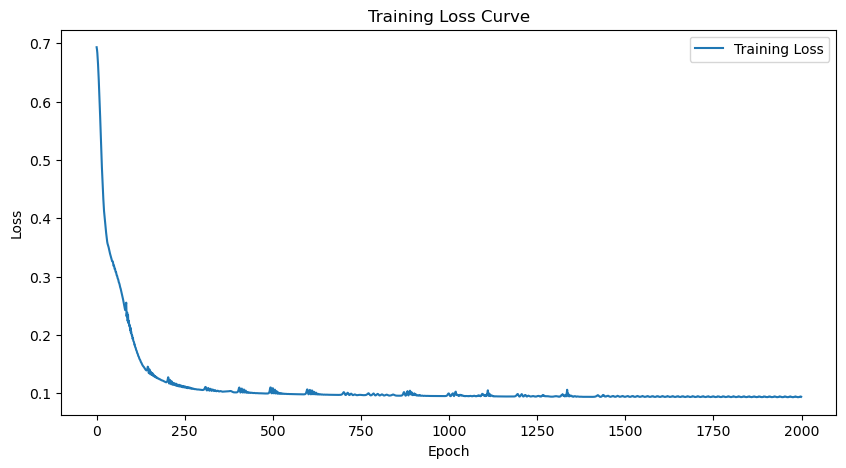

Final Model Accuracy: 75.53%
Final Model F1-score: 0.7646


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'.


In [ ]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 75.53%
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



/tmp/ipykernel_1446863/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 